# Basic CNN Framework for Landsat Classification

In [13]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

### importing datasets

In [14]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

landsat_dataset = rasterio.open('/deep_data/LC08_CU_028012_20140814_20171017_C01_V01_SR/combined.tif')


In [15]:
# What is the raster's projection?
image_proj = landsat_dataset.crs # 4326
print('Image projection:')
print(image_proj)

# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Labels projection:
EPSG:32618


## Data Generator and Prep Fcns

This is a typical Keras generator that I've written to allow it to ingest a set of random pixel locations so we can randomly sample throughout the images.

In [191]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count))
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            #print('Window is: ', c-buffer, r-buffer, tile_width, tile_height)
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (7, 3, 3):
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            else:
                tile = adjust_band(tile)
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)
              

This function takes in a list of raster datasets and randomly samples `train_count` and `val_count` random pixels from each dataset.

It doesn't sample within tile_size / 2 of the edge in order to avoid missing data.

In [17]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a randomly selected number of pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    total_count = train_count + val_count
    for index, image_dataset in enumerate(image_datasets):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count)
        
        dataset_index = [index] * total_count
        
        dataset_pixels = list(zip(points, dataset_index))
        
        train_pixels += dataset_pixels[:train_count]
        val_pixels += dataset_pixels[train_count:]
        
        
    return (train_pixels, val_pixels)

## Test out the generator and data prep functions

Let's make sure all this data prep actually works.

In [18]:
# generate the training and validation pixel locations
train_px, val_px = gen_pixel_locations([landsat_dataset], 100, 20, 11)

In [37]:
# print out some image and label batches and check out their shapes
im_batch = None

count = 0
for (im, label) in tile_generator([landsat_dataset], label_dataset, 11, 11, train_px, 2):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label)
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Window is:  3920 2401 11 11
Window is:  2685 2844 11 11
Window is:  4372 2470 11 11
Window is:  2252 3823 11 11
Row is:  3829 3835.0
Column is:  2258 2264.0
Window is:  3178 4661 11 11
Window is:  3229 1966 11 11
Window is:  2599 2430 11 11
Window is:  4736 3709 11 11
Window is:  711 1512 11 11
Row is:  1518 1524.0
Column is:  717 723.0
Window is:  4714 4541 11 11
Window is:  1082 3328 11 11
Row is:  3334 3340.0
Column is:  1088 1094.0
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(2, 23)
----
Window is:  971 3488 11 11
Row is:  3494 3500.0
Column is:  977 983.0
Window is:  1607 34 11 11
Row is:  40 46.0
Column is:  1613 1619.0
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Window is:  4660 616 11 11
Window is:  405 4009 11 11

### Visually inspect an image patch

While it shouldn't necessarily be recognizable it should look like it has data in it and that it varies somewhat from pixel to pixel.

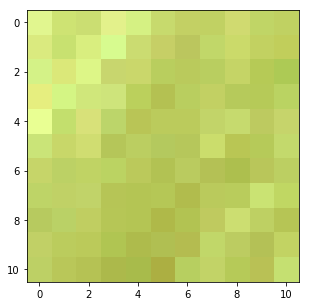

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,1:4])

## Let's get to the CNN Development!!

In [21]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [22]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### prep some of the hyperparameters

In [29]:
batch_size = 25
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
epochs = 50

# input image dimensions
img_rows, img_cols = 11, 11
img_bands = landsat_dataset.count

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(11, 11, 7)


### build the model

This is just a simple CNN model but it should be able to perform well above random when predicting landcover types if everything is correct thus far.

In [30]:
model = Sequential()
model.add(Conv2D(11, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(44, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 9, 9, 11)          704       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 22)          2200      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 22)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 22)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 198)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                8756      
_________________________________________________________________
dropout_4 (Dropout)          (None, 44)                0         
__________

#### Generate the train/validation pixel locations to train with

In [39]:
train_px, val_px = gen_pixel_locations(image_datasets=[landsat_dataset], 
                                       train_count=10000, val_count=50, tile_size=11)

#### set up the remaining model hyperparameters and compile

In [40]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

#### TRAIN THE MODEL!

In [41]:
model.fit_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator([landsat_dataset], label_dataset, 11, 11, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50
400/400 [==============================] - 19s 47ms/step - loss: 1.8434 - acc: 0.3767 - val_loss: 1.7041 - val_acc: 0.5000
Epoch 2/50
400/400 [==============================] - 11s 29ms/step - loss: 1.7871 - acc: 0.3930 - val_loss: 1.7434 - val_acc: 0.3600
Epoch 3/50
400/400 [==============================] - 12s 29ms/step - loss: 1.7580 - acc: 0.4013 - val_loss: 1.8121 - val_acc: 0.3200
Epoch 4/50
400/400 [==============================] - 12s 29ms/step - loss: 1.7390 - acc: 0.4032 - val_loss: 1.8394 - val_acc: 0.3800
Epoch 5/50
400/400 [==============================] - 11s 28ms/step - loss: 1.7173 - acc: 0.4085 - val_loss: 1.7874 - val_acc: 0.3600
Epoch 6/50
400/400 [==============================] - 11s 29ms/step - loss: 1.7071 - acc: 0.4122 - val_loss: 1.7671 - val_acc: 0.4400
Epoch 7/50
400/400 [==============================] - 11s 29ms/step - loss: 1.6857 - acc: 0.4187 - val_loss: 1.8103 - val_acc: 0.3000
Epoch 8/50
400/400 [==============================] - 12s 29ms

KeyboardInterrupt: 

### Now let's evaluate the Model

We'll just generate 500 test pixels to evaluate it on

In [42]:
test_px, val_px = gen_pixel_locations([landsat_dataset], train_count=500, val_count=0, tile_size=11)

Keras has a built in evaluate_generator function and because we told it above to use accuracy as a metric this function automatically outputs categorical accuracy which is what we want.

In [43]:
model.evaluate_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

20/20 [==============================] - 7s 373ms/step


[1.4529894500970841, 0.42999999672174455]

So in this simple model we're getting 37% accuracy across 23 classes which is well above the random accuracy which would be around 4% (aka 1/23). That means we're in business!

### Evaluating the model ourselves

If we wanted to run this evaluation and take a look at specific predictions and labels we can do that below (albeit more inefficiently) just to get an intuitive understanding of what is going wrong.

In [44]:
predictions = model.predict_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)


20/20 [==============================] - 7s 373ms/step


In [45]:
eval_generator = tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size=1)

In [46]:
labels = np.empty(predictions.shape)
count = 0
while count < len(test_px):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

In [47]:
labels.shape

(500, 23)

In [48]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

In [49]:
label_index[:10]

array([10, 21, 13, 13, 13, 12, 14, 20, 14,  6])

In [50]:
pred_index[:10]

array([13, 21, 13, 13, 13, 13, 13,  6, 10,  6])

In [51]:
correct_predictions = np.zeros(pred_index.shape)
correct_predictions[label_index == pred_index] = 1

In [52]:
correct_predictions[:20]

array([0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0.])

In [53]:
np.count_nonzero(correct_predictions) / len(test_px)

0.43

In [54]:
predictions[:3]

array([[1.39456133e-05, 1.08397144e-05, 1.32456535e-05, 1.39628737e-05,
        7.08378066e-05, 2.29373807e-04, 1.92839596e-02, 2.78963744e-05,
        5.13027571e-02, 3.23570310e-03, 1.73029929e-01, 4.76502366e-02,
        1.30337730e-01, 4.12347794e-01, 1.37362242e-01, 2.28029080e-02,
        1.02808590e-05, 2.99559124e-05, 1.00864389e-04, 1.86257130e-05,
        1.45686220e-03, 6.38351950e-04, 1.17201125e-05],
       [6.67261639e-16, 9.79078965e-17, 1.11945577e-12, 1.11583007e-15,
        2.47678141e-19, 2.59461510e-19, 1.34758799e-21, 1.29068631e-17,
        6.89967734e-16, 4.03871053e-16, 7.99841549e-18, 1.08974918e-15,
        2.08465768e-18, 1.18255053e-15, 5.75881302e-14, 2.56063657e-07,
        3.23693289e-18, 8.56284643e-08, 1.38859404e-03, 9.14767142e-08,
        2.71886569e-10, 9.98610973e-01, 8.80435987e-20],
       [9.48453890e-05, 1.14659539e-04, 1.42685021e-04, 1.53468020e-04,
        3.42327141e-04, 7.56670779e-04, 1.02356635e-02, 2.00687005e-04,
        4.07472476e-02

In [55]:
np.argmax(predictions, axis=1)[:20]

array([13, 21, 13, 13, 13, 13, 13,  6, 10,  6,  6,  6, 13, 21,  6, 13, 13,
        6, 13, 13])

In [56]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now maybe more informatively let's build a confusion matrix using the scikit-learn function.

Read the docs here and make this more informative by following some of their examples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
conf_matrix = confusion_matrix(label_index, pred_index)

In [59]:
conf_matrix

array([[ 0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  0, 51,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 15,  0,  6,  0,  0,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  4,  0,  0, 62,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 28,  0, 11,  0,  0, 25,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 17,  0, 16,  0,  5, 80,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  6,  0,  0,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  3,  0,  0,  0,  0,  3],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  6],
       [ 0,  2,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0, 72]])

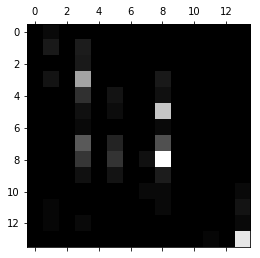

In [60]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)

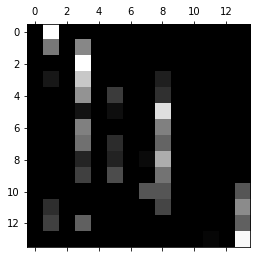

In [61]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)

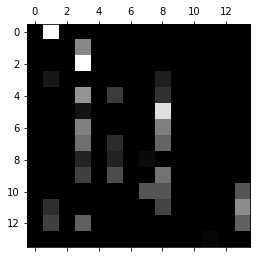

In [62]:
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)

## Scikit-learn ML Approaches

In [67]:
def pixel_generator(image_datasets, label_dataset, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
  
    image_batch = np.zeros((batch_size, band_count))
    label_batch = np.zeros((batch_size, class_count))
    b = 0
    while b < batch_size:
        # if we're at the end  of the data just restart
        if i >= len(pixel_locations):
            i=0
        c, r = pixel_locations[i][0]
        dataset_index = pixel_locations[i][1]
        i += 1
        tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c, r, 1, 1))
        if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
            pass
        elif np.isnan(tile).any() == True or -9999 in tile: 
            # we don't want tiles containing nan or -9999 this comes from edges
            # this also takes a while and is inefficient
            pass
        else:
            tile = adjust_band(tile)
            # reshape from raster format to image format
            reshaped_tile = reshape_as_image(tile)

            # find gps of that pixel within the image
            (x, y) = image_datasets[dataset_index].xy(r, c)

            # convert the point we're sampling from to the same projection as the label dataset if necessary
            inProj = Proj(image_datasets[dataset_index].crs)
            if inProj != outProj:
                x,y = transform(inProj,outProj,x,y)

            # reference gps in label_image
            row, col = label_dataset.index(x,y)

            # find label
            label = label_image[:, row, col]
            # if this label is part of the unclassified area then ignore
            if label == 0 or np.isnan(label).any() == True:
                pass
            else:
                # add label to the batch in a one hot encoding style
                label_batch[b][label] = 1
                image_batch[b] = reshaped_tile
                b += 1
    return (image_batch, label_batch)
              

In [201]:
def sk_tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height*tile_width*band_count))
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            #print('Window is: ', c-buffer, r-buffer, tile_width, tile_height)
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (7, 3, 3):
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            else:
                tile = adjust_band(tile)
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    # we have to add it in a single flat array here
                    image_batch[b] = reshaped_tile.flatten()
                    b += 1
        return (image_batch, label_batch)
              

### Prep Data for training and validation

In [211]:
train_px, val_px = gen_pixel_locations([landsat_dataset], 50000, 1000, 1)

In [212]:
batch_size = 50000
sk_im_batch, sk_label_batch = pixel_generator([landsat_dataset], label_dataset, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

(50000, 7) (50000, 23)


In [213]:
batch_size = 1000
sk_im_batch_val, sk_label_batch_val = pixel_generator([landsat_dataset], label_dataset, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(1000, 7) (1000, 23)


### K Nearest Neighbors

In [232]:
from sklearn import neighbors, datasets

n_neighbors = 50

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='distance')

In [233]:
clf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.474

In [155]:
clf.predict_proba(sk_im_batch_val)[0]

array([0.  , 0.  , 0.  , 0.04, 0.44, 0.  , 0.06, 0.  , 0.1 , 0.  , 0.1 ,
       0.12, 0.04, 0.06, 0.  , 0.  , 0.  , 0.04, 0.  ])

In [234]:
pred_index = clf.predict(sk_im_batch_val)

In [235]:
conf_matrix = confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index)

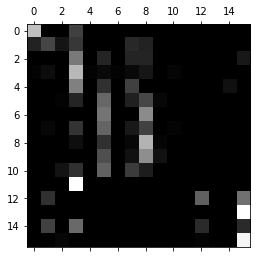

In [236]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
plt.matshow(np.nan_to_num(norm_conf_matrix), cmap=plt.cm.gray)

(array([  8.,  37.,  21., 136.,   0.,  32.,   0., 164.,  22.,   0., 104.,
        218.,  72.,  26.,   0.,   2.,  16.,   6.,  12., 124.]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ,
        12.9, 13.8, 14.7, 15.6, 16.5, 17.4, 18.3, 19.2, 20.1, 21. ]),
 <a list of 20 Patch objects>)

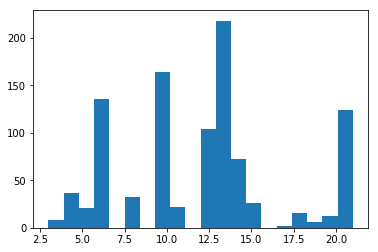

In [239]:
plt.hist(np.argmax(sk_label_batch_val, axis=1), bins=20)

(array([ 13.,  26.,  10., 203.,   0.,   2.,   0., 204.,   2.,   0.,  70.,
        302.,  15.,   5.,   0.,   0.,  10.,   0.,   2., 136.]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ,
        12.9, 13.8, 14.7, 15.6, 16.5, 17.4, 18.3, 19.2, 20.1, 21. ]),
 <a list of 20 Patch objects>)

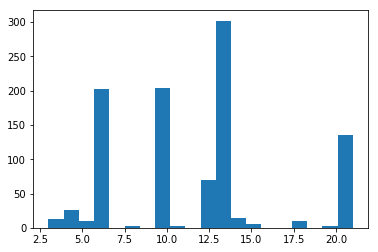

In [238]:
plt.hist(pred_index, bins=20)

### Random Forest

In [240]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [241]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 100.0%


In [242]:
rf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.462

In [243]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.061721785871233836
Band 2 importance: 0.18716306680302258
Band 3 importance: 0.19028680883539745
Band 4 importance: 0.17525848443950656
Band 5 importance: 0.02033311186091988
Band 6 importance: 0.16036940889418527
Band 7 importance: 0.20486733329573442


In [244]:
pred_index = rf.predict(sk_im_batch_val)

(array([ 12.,  28.,   7., 197.,   0.,   8.,   0., 189.,   3.,   0.,  74.,
        299.,  36.,   7.,   0.,   0.,   4.,   2.,   4., 130.]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ,
        12.9, 13.8, 14.7, 15.6, 16.5, 17.4, 18.3, 19.2, 20.1, 21. ]),
 <a list of 20 Patch objects>)

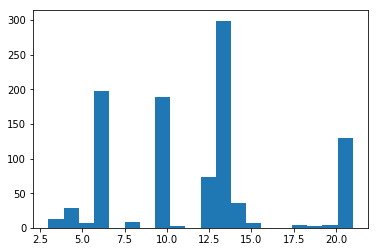

In [245]:
plt.hist(pred_index, bins=20)

#### Creating training data that contains a 3x3 tile

In [199]:
batch_size = 50000
sk_im_batch, sk_label_batch = sk_tile_generator([landsat_dataset], label_dataset, 3, 3, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

(10000, 63) (10000, 23)


In [200]:
batch_size = 500
sk_im_batch_val, sk_label_batch_val = sk_tile_generator([landsat_dataset], label_dataset, 3, 3, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(500, 63) (500, 23)


In [202]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [203]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 50.05%


In [209]:
rf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.436

In [204]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.01622500382510033
Band 2 importance: 0.01505835675357486
Band 3 importance: 0.013818720593991562
Band 4 importance: 0.012026276887924563
Band 5 importance: 0.011844958898888756
Band 6 importance: 0.012315265122301543
Band 7 importance: 0.01318380879430869


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


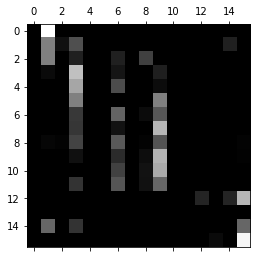

In [206]:
pred_index = rf.predict(sk_im_batch_val)
conf_matrix = confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
plt.matshow(np.nan_to_num(norm_conf_matrix), cmap=plt.cm.gray)

### SVM

In [223]:
from sklearn import svm
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [224]:
svm_clf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

0.402

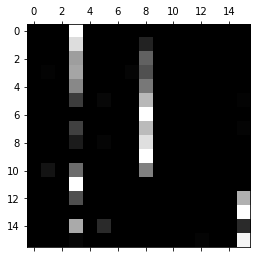

In [225]:
pred_index = svm_clf.predict(sk_im_batch_val)
conf_matrix = confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
plt.matshow(np.nan_to_num(norm_conf_matrix), cmap=plt.cm.gray)

In [ ]:
# get a balanced percent of each class
# look at the classes that are consistently mis classified
# think about adding NDVI or taking out bands


In [247]:
np.unique(pred_index)

array([ 3,  4,  5,  6,  8, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21])

In [252]:
np.unique(np.argmax(sk_label_batch_val, axis=1))

array([ 3,  4,  5,  6,  8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21])

In [249]:
norm_conf_matrix[0]

array([0.75, 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [251]:
conf_matrix.shape

(16, 16)

In [268]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

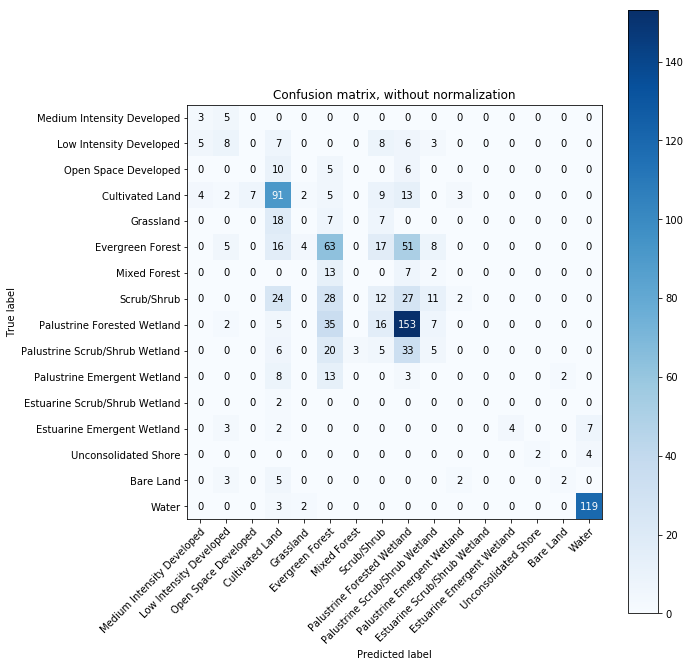

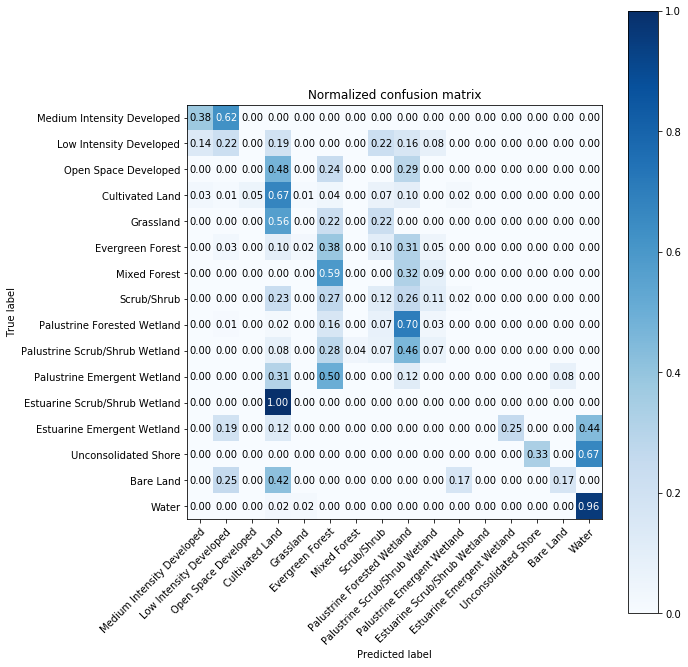

In [292]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

plt.show()